In [164]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

In [165]:
population_size = 50
chromosome_length = 56
p_c = 0.9
p_m = 0.025
generation_num = 100
best_value = 1e-9

In [166]:
def create_population(population_size):
  population = []
  for idx in range(population_size):
    chromosome = []
    for n in range(8):
      binary_array = [random.randint(0,1) for j in range(7)]
      chromosome.append(binary_array)
    chromosome = np.array(chromosome)
    chromosome = chromosome.flatten()
    population.append(chromosome)
  population = np.array(population)
  return population

In [167]:
def decode_chromosome(chromosome):
    result_length = int(len(chromosome)/7)
    # Mảng kết quả
    result = [0] * result_length

    for i in range(result_length):
      # Lấy 7 bit từ vị trí i*7
      binary_num = chromosome[i*7: i*7 + 7]
    
      # Chuyển đổi sang số thập phân
      decimal_num = 0
      j = 0
      for bit in binary_num:
        decimal_num += bit * math.pow(2, j)
        j += 1
        decimal_num /= 127
      # Lưu kết quả
      result[i] = decimal_num
    return result

In [168]:
def decode(population):
  float_nums = []
  for chromosome in population:
    result = decode_chromosome(chromosome)
    float_nums.append(result)
  return(float_nums)

In [169]:
hip_joints = np.array([[-120, -165], [120, -165], [-120, -55], [120, -55], [-120, 55], [120, 55], [-120, 165], [120, 165]])
L1 = 230.15 # Khoang cach tu hong den dau goi (mm)
L2 = 149    # Khoang cach tu dau goi den ban chan (mm)

In [170]:
# Plot the points
# plt.plot(hip_joints[:,0], hip_joints[:,1], 'ro')

# # Add labels and show plot
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Points')
# plt.show()

In [171]:
def find_contact_points(float_population):
  foot_points = []
  for float_num in float_population:
    contact_points = []
    for index, value in enumerate(float_num):
      if value >= 0.5:
        q = 1/4 * np.pi * value
        if index % 2 ==0:
          knee_joint = hip_joints[index] - L1 * np.array([np.cos(q), np.sin(q)])
          contact_point = knee_joint + L2 * np.array([np.cos(q), np.sin(q)])
        else:
          knee_joint = hip_joints[index] + L1 * np.array([np.cos(q), np.sin(q)])
          contact_point = knee_joint - L2 * np.array([np.cos(q), np.sin(q)])
        contact_points.append(contact_point)
    contact_points = np.array(contact_points)
    foot_points.append(contact_points)
  return foot_points

In [172]:
# Robot parameters
# leg_position = leg_positions[0] # List of (x,y,z) coordinates of each leg contact point  
link_lengths = [230.15, 149] # List of lengths of links between body and each leg
body_width = 100
body_depth = 100

def find_center_of_mass(leg_position):
  if len(leg_position) >= 3:
    # Get average leg position
    x_avg = np.mean([p[0] for p in leg_position])  
    y_avg = np.mean([p[1] for p in leg_position])

    # Approximate body COM at center of body
    com_x = x_avg
    com_y = y_avg

    # Account for offset of links
    
    for i, link_len in enumerate(link_lengths):
      leg_pos = leg_position[i]
      dx = leg_pos[0] - (com_x - link_len/2) 
      dy = leg_pos[1] - (com_y - link_len/2)

      com_x += dx/len(leg_position)
      com_y += dy/len(leg_position)
  else:
    com_x = com_y = 1e-10

  # Adjust for non-point body  
  com_x -= body_width/2
  com_y -= body_depth/2

  return np.array([com_x, com_y])
# print("Estimated COM:", com_x, com_y)

In [173]:
from scipy.spatial import ConvexHull

In [174]:
def draw_stability_margin(leg_positions, center_of_mass):
  # Define support polygon 
  support_points = []

  # Get x,y positions of legs in contact
  for i, leg in enumerate(leg_positions):  
    # if leg['contact']:  
    support_points.append([leg[0], leg[1]])

  # Calculate convex hull 
  hull = ConvexHull(support_points)

  for simplex in hull.simplices:
    p1 = leg_positions[simplex[0]] 
    p2 = leg_positions[simplex[1]]
    plt.plot([p1[0],p2[0]], [p1[1],p2[1]],'r-')
  plt.plot(center_of_mass[0], center_of_mass[1], 'ro')


In [175]:
def calc_stability_margin(leg_position, center_of_mass):
  if len(leg_position) <= 3:
    return 1e-10
  else:

    xmax = max(x for x,y in leg_position)
    xmin = min(x for x,y in leg_position)

    ymax = max(y for y,y in leg_position)
    ymin = min(y for y,y in leg_position)

    distances = [math.sqrt((x-center_of_mass[0])**2 + (y-center_of_mass[1])**2)
                for x,y in leg_position]

    distance = min(distances)

    size = max(xmax-xmin, ymax-ymin)

    return distance/size

In [176]:
def find_fitness(population):
    float_nums = decode(population)
    leg_positions = find_contact_points(float_nums)
    center_of_mass = []
    for i in range(len(leg_positions)):
        com = find_center_of_mass(leg_positions[i])
        center_of_mass.append(com)
    fitness = []
    for i in range(len(leg_positions)):
        sm = calc_stability_margin(leg_positions[i], center_of_mass[i])
        fitness.append(sm**2)
    return fitness

In [177]:
def tournament_selection(population, fitnesses, size = 16, n_selected = 4):
  
  # Tournament selection
  selected = []
  indices = list(range(len(population)))
  subset =  random.sample(indices, size)
  for _ in range(n_selected):

    # Select 2 random candidates
    c1_idx = random.sample(subset, 1)[0]
    while True:
      c2_idx = random.sample(subset, 1)[0]
      if c2_idx != c1_idx:
        break
    
    # # Compare stability margins
    c1 = fitnesses[c1_idx]
    c2 = fitnesses[c2_idx]

    if c1 <= c2:
      winner_idx = c1_idx
    else:
      winner_idx = c2_idx

    # # Add winner to selected
    selected.append(winner_idx)

  # # Print selected indices
  # print("Selected indices:", selected)

  # # Print actual values
  # for i in selected:
  #   print("Value:", population[i])
  return selected

In [178]:
def select_random(selected_parents):
  n = len(selected_parents)

  index1 = random.randint(0, n-1)
  parent1 = selected_parents[index1]
  while True:
    index2 = random.randint(0, n-1)
    parent2 = selected_parents[index2]
    if index1 != index2:
      break

  return parent1, parent2

In [179]:
# Breeding at a random point
def crossover(p1, p2):
    crossover_point = random.randint(0, (len(p1) - 1))
    child1 = np.copy(p1)
    child2 = np.copy(p2)
    child1[:crossover_point] = p1[:crossover_point]; child1[crossover_point:] = p2[crossover_point:]
    child2[:crossover_point] = p2[:crossover_point]; child2[crossover_point:] = p1[crossover_point:]
    return child1, child2

In [180]:
def mutation(chromosome):
  for i in range(10):
    index = random.randint(0, len(chromosome) - 1)
    chromosome[index] = 1 - chromosome[index]
  return chromosome

In [181]:
# Genetic Algorithm
best_value = 1e-9
population = create_population(population_size)

for iter in range(generation_num):

    selected_parents = []
    for i in range(population_size):
        if random.random() < p_c:
            selected_parents.append(population[i])

    for _ in range(len(selected_parents)):
        p1, p2 = select_random(selected_parents)
        c1, c2 = crossover(p1, p2)
        if random.random() < p_m:
            if random.random() < 0.5:
                c1 = mutation(c1)
            else:
                c2 = mutation(c2)

        population = np.vstack((population, c1))
        population = np.vstack((population, c2))

    fitnesses = find_fitness(population)
    best_index = np.argmax(fitnesses)
    new_population = []
    new_population.append(population[best_index].copy())

    for _ in range(population_size - 1):
        selected = tournament_selection(population, fitnesses, size = 8, n_selected = 1)
        # selected = random.randint(0, len(population) - 1)
        new_population.append(population[selected[0]].copy())

    if max(fitnesses) > best_value:
        best_value = max(fitnesses)

    population = new_population
    # print(population[0])
    best_chrom = decode_chromosome(new_population[0])
    print(f'At interation {iter} max value is {max(fitnesses)} at {best_chrom}')
print(f'Best value is {best_value} at {best_chrom}')

At interation 0 max value is 0.2823575190971272 at [0.5039370387472101, 0.0019918458809249557, 3.087319623540536e-08, 1.8766096848324404e-15, 4.766588599474398e-13, 0.5059210425946233, 0.5039448496653848, 0.5039448189137384]
At interation 1 max value is 0.2823575190971272 at [0.5039370387472101, 0.0019918458809249557, 3.087319623540536e-08, 1.8766096848324404e-15, 4.766588599474398e-13, 0.5059210425946233, 0.5039448496653848, 0.5039448189137384]
At interation 2 max value is 0.2823575190971272 at [0.5039370387472101, 0.0019918458809249557, 3.087319623540536e-08, 1.8766096848324404e-15, 4.766588599474398e-13, 0.5059210425946233, 0.5039448496653848, 0.5039448189137384]
At interation 3 max value is 0.2823575191073681 at [0.5039370386261406, 0.0019918457593769466, 3.087319623540536e-08, 1.8766096848324404e-15, 4.766588599474398e-13, 0.5059210425946233, 0.5039448496653848, 0.5039448189137384]


At interation 4 max value is 0.2823575191073681 at [0.5039370386261406, 0.0019918457593769466, 3.087319623540536e-08, 1.8766096848324404e-15, 4.766588599474398e-13, 0.5059210425946233, 0.5039448496653848, 0.5039448189137384]
At interation 5 max value is 0.2823575191073681 at [0.5039370386261406, 0.0019918457593769466, 3.087319623540536e-08, 1.8766096848324404e-15, 4.766588599474398e-13, 0.5059210425946233, 0.5039448496653848, 0.5039448189137384]
At interation 6 max value is 0.2823575191073681 at [0.5039370386261406, 0.0019918457593769466, 3.087319623540536e-08, 1.8766096848324404e-15, 4.766588599474398e-13, 0.5059210425946233, 0.5039448496653848, 0.5039448189137384]
At interation 7 max value is 0.2823575191073681 at [0.5039370386261406, 0.0019918457593769466, 3.087319623540536e-08, 1.8766096848324404e-15, 4.766588599474398e-13, 0.5059210425946233, 0.5039448496653848, 0.5039448189137384]
At interation 8 max value is 0.2823575191073681 at [0.5039370386261406, 0.0019918457593769466, 3.087

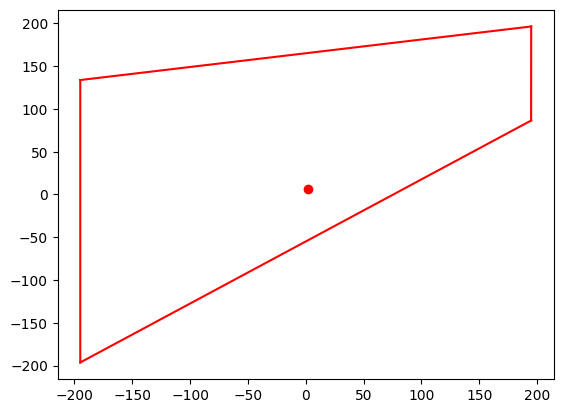

In [182]:
contact_points = []
for index, value in enumerate(best_chrom):
    if value >= 0.5:
        q = 1/4 * np.pi * value
        if index % 2 ==0:
            knee_joint = hip_joints[index] - L1 * np.array([np.cos(q), np.sin(q)])
            contact_point = knee_joint + L2 * np.array([np.cos(q), np.sin(q)])
        else:
            knee_joint = hip_joints[index] + L1 * np.array([np.cos(q), np.sin(q)])
            contact_point = knee_joint - L2 * np.array([np.cos(q), np.sin(q)])
        contact_points.append(contact_point)
leg_position = np.array(contact_points)
com = find_center_of_mass(leg_position)
draw_stability_margin(leg_position, com)